In [38]:
from IPython.display import display, Image, clear_output

# Comprehensive Lipidome Automation Workflow (CLAW)

Welcome to CLAW, a tool designed to facilitate and optimize the processing of lipidomic MRM data. This Jupyter notebook encapsulates a suite of tools that streamline the various stages of lipidomics data analysis.

Our toolset enables users to efficiently process MRM data files in the mzML format. Upload a file and CLAW will parse the data into a structured Pandas dataframe. This dataframe includes critical information like sample_ID, MRM transition, and signal intensity. Furthermore, our tool aligns each MRM transition with a default or custom lipid_database for accurate and swift annotation.

Moreover, CLAW is equipped with an OzESI option, a tool to elucidate the double bond location in lipid isomers. This feature allows users to input OzESI data and pinpoint the precise location of double bonds in isomeric lipids. Users have the flexibility to select which double bond locations they want to analyze. Following this, CLAW autonomously predicts potential m/z values and cross-references these predictions with sample data, ensuring a comprehensive and meticulous analysis.

With automation at its core, CLAW eliminates the need for manual data processing, significantly reducing time expenditure. It is a robust and invaluable tool for handling large volumes of lipid MRM data, accelerating scientific discovery in the field of lipidomics.

In [39]:
#Import all the necessary python libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json
from scipy.integrate import trapz

#Import all the necessary CLAW libraries
import create_directory
import CLAW
import matplotlib.pyplot as plt
import warnings

import re
from sklearn.mixture import GaussianMixture
from tqdm import tqdm  # This imports the tqdm function for progress bars


# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Directory and File Management
For structured data management and efficient workflow, the system first ensures the presence of an output directory. If such a directory already exists you can skip this step.

In [40]:
# # Create the output directory. If it already exists you can skip this step.
# create_directory.create_project_folder()


The name of the project is defined next. This is important as the created directory will bear this name, allowing users to manage and identify their data with ease.

After the mzML files are uploaded to the designated mzML folder, the next block of code segregates these files based on their characteristics. More specifically, it filters the files and transfers them to respective folders named 'o3on' and 'o2only'.

In [41]:
name_of_project = 'FaceFats'
#After you load mzml files to mzml folder. this will filter the files and move them to o3on and o2only folders
create_directory.filter_o3mzml_files(name_of_project)

One or both of the destination directories 'Projects/FaceFats/o3on' and 'Projects/FaceFats/o2only' do not exist.


## Pre-Parsing Setup
The following block of code takes the preset variable values and uses them to parse the mzML files. The parsed data, including the sample ID, MRM transitions, and intensities, is stored in a pandas dataframe for easy manipulation and analysis.

The function CLAW.parsing_mzml_to_df takes several arguments. data_base_name_location is the location of the lipid database that contains information on lipid classes, fatty acid chains, and their corresponding MRM transitions. Project_Folder_data is the location of the mzML files for the samples to be analyzed. tolerance defines the acceptable range of deviation for the MRM transitions when matching them with the lipid database. The argument remove_std is a boolean that, when True, indicates to remove the MRM transitions that correspond to standards (internal or external) present in the samples.

The function outputs a pandas dataframe (df) where each row corresponds to an MRM transition detected in a sample, and columns include the sample ID, MRM transition, and intensity of the transition, among other values.

In [42]:
# Set default values
data_base_name_location = 'lipid_database/Lipid_Database.xlsx'
Project = './Projects/'
Project_Name = 'FaceFats'
Project_Folder_data = Project + Project_Name + '/mzml_brain5xFAD_OzON/'
Project_results = Project + Project_Name + '/results/'
file_name_to_save = 'Brain5xFAD_OzON'
tolerance = 0.3
remove_std = True
save_data = True

# Call pre_parsing_setup to initialize the variables
data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std, save_data = CLAW.pre_parsing_setup(data_base_name_location,
 Project, 
 Project_Name, 
 Project_Folder_data,
 Project_results, 
 file_name_to_save, 
 tolerance, 
 remove_std,
 save_data)


data_base_name_location: lipid_database/Lipid_Database.xlsx
Project: ./Projects/
Project_Name: FaceFats
Project_Folder_data: ./Projects/FaceFats/mzml_brain5xFAD_OzON/
Project_results: ./Projects/FaceFats/results/
file_name_to_save: Brain5xFAD_OzON
tolerance: 0.3
remove_std: True
save_data: True


Define the master dataframes where the data will be stored during the parsing step.

In [43]:
time_and_intensity_df, master_df, OzESI_time_df = CLAW.create_analysis_dataframes()

## CLAW.full_parse()
In this code, the `CLAW.full_parse()` function is used to analyze the MRM data. It takes several parameters like the location of the lipid database, paths to the data and results folders, the name of the result files, and the tolerance for MRM transitions matching. The function returns two dataframes: `df_matched` that contains information about each detected lipid species and their corresponding MRM transitions, and `OzESI_time_df` which captures data related to OzESI-MS scans, including potential double bond locations of lipids. If `remove_std` is `True`, it removes MRM transitions related to standards from the dataframe, and if `save_data` is `True`, the dataframe is saved as a .csv file in the specified results folder.

In [44]:
# Use the initialized variables as arguments to full_parse
df_MRM, df_OzESI = CLAW.full_parse(data_base_name_location, 
                                               Project_Folder_data, 
                                               Project_results, 
                                               file_name_to_save, 
                                               tolerance, 
                                               remove_std=True, 
                                               save_data=False,
                                               batch_processing=True,
                                               plot_chromatogram=False)

/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Parent_Ion'] = np.round(lipid_MRM_data['Parent_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Product_Ion'] = np.round(lipid_MRM_data['Product_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON/11292023_DOD93_F4_5xFAD_cereb_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON/11292023_DOD93_F4_5xFAD_cortex_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON/11292023_DOD93_F4_5xFAD_dienc_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON/11292023_DOD93_F4_5xFAD_hippo_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON/11292023_DOD94_F4_5xFAD_cereb_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON/11292023_DOD94_F4_5xFAD_cortex_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON/11292023_DOD94_F4_5xFAD_dienc_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON/11292023_DOD94_F4_5xFAD_hippo_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_brain5xFAD_OzON/11292023_FAD185_M1_5xFAD_

In [45]:
df_MRM.head(None)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition
0,NaN,25452.201778,NaN,584.4,437.3,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
1,NaN,23887.601665,NaN,612.4,437.3,11292023_DOD93_F4_5xFAD_cereb_O3on_01,612.4 -> 437.3
2,NaN,32008.842213,NaN,622.5,503.4,11292023_DOD93_F4_5xFAD_cereb_O3on_01,622.5 -> 503.4
3,NaN,28793.361992,NaN,624.5,505.4,11292023_DOD93_F4_5xFAD_cereb_O3on_01,624.5 -> 505.4
4,NaN,25249.781784,NaN,626.5,437.3,11292023_DOD93_F4_5xFAD_cereb_O3on_01,626.5 -> 437.3
...,...,...,...,...,...,...,...
4195,TAG,25292.741741,"[TG(57:9),TG(56:2)]_FA18:1",932.9,633.6,11292023_FAD189_M2_5xFAD_hippo_O3on_01,932.9 -> 633.6
4196,TAG,23646.801674,"[TG(58:7),TG(57:0)]_FA18:1",950.9,651.6,11292023_FAD189_M2_5xFAD_hippo_O3on_01,950.9 -> 651.6
4197,TAG,23767.581665,"[TG(59:13),TG(58:6)]_FA18:1",952.8,653.5,11292023_FAD189_M2_5xFAD_hippo_O3on_01,952.8 -> 653.5
4198,TAG,23726.221684,"[TG(59:12),TG(58:5)]_FA18:1",954.8,655.5,11292023_FAD189_M2_5xFAD_hippo_O3on_01,954.8 -> 655.5


Group for df_MRM as well

In [46]:
# Creating the Match_Group column
df_MRM['Match_Group'] = df_MRM.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()

# Display the DataFrame with the new column
df_MRM

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition,Match_Group
0,NaN,25452.201778,NaN,584.4,437.3,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0
1,NaN,23887.601665,NaN,612.4,437.3,11292023_DOD93_F4_5xFAD_cereb_O3on_01,612.4 -> 437.3,24
2,NaN,32008.842213,NaN,622.5,503.4,11292023_DOD93_F4_5xFAD_cereb_O3on_01,622.5 -> 503.4,48
3,NaN,28793.361992,NaN,624.5,505.4,11292023_DOD93_F4_5xFAD_cereb_O3on_01,624.5 -> 505.4,72
4,NaN,25249.781784,NaN,626.5,437.3,11292023_DOD93_F4_5xFAD_cereb_O3on_01,626.5 -> 437.3,96
...,...,...,...,...,...,...,...,...
4195,TAG,25292.741741,"[TG(57:9),TG(56:2)]_FA18:1",932.9,633.6,11292023_FAD189_M2_5xFAD_hippo_O3on_01,932.9 -> 633.6,3359
4196,TAG,23646.801674,"[TG(58:7),TG(57:0)]_FA18:1",950.9,651.6,11292023_FAD189_M2_5xFAD_hippo_O3on_01,950.9 -> 651.6,3383
4197,TAG,23767.581665,"[TG(59:13),TG(58:6)]_FA18:1",952.8,653.5,11292023_FAD189_M2_5xFAD_hippo_O3on_01,952.8 -> 653.5,3407
4198,TAG,23726.221684,"[TG(59:12),TG(58:5)]_FA18:1",954.8,655.5,11292023_FAD189_M2_5xFAD_hippo_O3on_01,954.8 -> 655.5,3431


In [47]:
df_OzESI.head(None)
# df_OzESI.to_csv('FF_OzOFF_full.csv')
# df_OzESI.to_excel('FaceFatsOzdf.xlsx')

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,584.4,437.3,0.044183,41.720001,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
1,NaN,584.4,437.3,0.088567,41.680004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
2,NaN,584.4,437.3,0.132967,41.240002,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
3,NaN,584.4,437.3,0.177367,41.800003,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
4,NaN,584.4,437.3,0.221783,41.640003,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
...,...,...,...,...,...,...,...
2364569,NaN,956.9,657.6,24.779100,42.380005,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6
2364570,NaN,956.9,657.6,24.823517,42.180004,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6
2364571,NaN,956.9,657.6,24.867917,42.180004,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6
2364572,NaN,956.9,657.6,24.912317,42.240002,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6


The `read_mrm_list()` function is first invoked to read the MRM database from the specified file location and return it as a pandas DataFrame `mrm_database`. Subsequently, the `match_lipids_parser()` function is called to match the detected lipids from the `OzESI_time_df` DataFrame, obtained from the OzESI-MS scans, with the known lipids in the `mrm_database` based on the MRM transitions within the specified `tolerance`. The result is saved in the `df_oz_matched` DataFrame, which now contains matched lipid species from the OzESI-MS data.

In [48]:
d1 = df_OzESI.iloc[:,1:9]

# Assuming d1 is your DataFrame

# Define the retention time range as a tuple (lower_bound, upper_bound)
retention_time_range = (9.5, 21.5)  # Replace with your specific range values

# Filter the DataFrame to keep only rows where Retention_Time is within the specified range
d1a = d1[(d1['Retention_Time'] >= retention_time_range[0]) & (d1['Retention_Time'] <= retention_time_range[1])]

# # Now, filtered_d1 contains only the rows from d1 where Retention_Time is within the specified range
# filtered_d1.to_csv('filtered_d1_FF_OzON_Liver.csv')
d1a

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
213,584.4,437.3,9.502833,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
214,584.4,437.3,9.547233,41.900002,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
215,584.4,437.3,9.591633,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
216,584.4,437.3,9.636050,41.700005,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
217,584.4,437.3,9.680450,41.640003,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3
...,...,...,...,...,...,...
2364491,956.9,657.6,21.315350,41.960003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6
2364492,956.9,657.6,21.359767,42.100002,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6
2364493,956.9,657.6,21.404167,42.140003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6
2364494,956.9,657.6,21.448583,42.160004,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6


# create Group for OzESI df to iterate through it faster instead of checking every single row

In [49]:
# Creating the Match_Group column
d1a['Match_Group'] = d1a.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()

# Display the DataFrame with the new column
d1a

/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group
213,584.4,437.3,9.502833,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0
214,584.4,437.3,9.547233,41.900002,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0
215,584.4,437.3,9.591633,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0
216,584.4,437.3,9.636050,41.700005,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0
217,584.4,437.3,9.680450,41.640003,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0
...,...,...,...,...,...,...,...
2364491,956.9,657.6,21.315350,41.960003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455
2364492,956.9,657.6,21.359767,42.100002,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455
2364493,956.9,657.6,21.404167,42.140003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455
2364494,956.9,657.6,21.448583,42.160004,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455


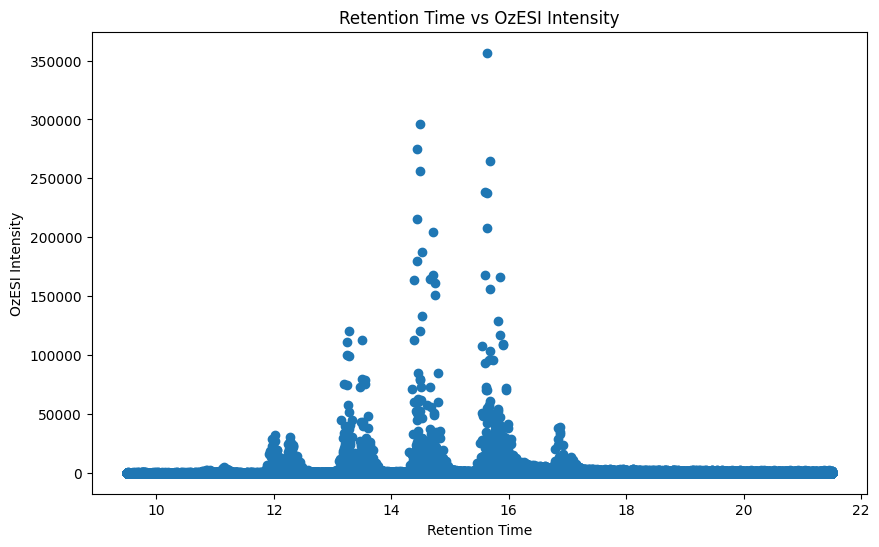

In [50]:


# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d1a['Retention_Time'], d1a['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


# Pipeline for OzON Truth

# d1a to d1b take raw dataframe and Match Lipids

In [51]:
d1b = d1a.copy()

# Assuming df_MRM and d1b are already defined

# Create Match_Group in d1a if it doesn't exist
if 'Match_Group' not in d1a.columns:
    d1a['Match_Group'] = d1a.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()

# Copy Match_Group to d1b
d1b['Match_Group'] = d1a['Match_Group']

# Function to check if two ions are within the tolerance
def is_within_tolerance(ion1, ion2, tolerance=0.3):
    return abs(ion1 - ion2) <= tolerance

# Add a new column for Lipid in d1b
d1b['Lipid'] = None

# Iterate through each unique Match_Group in d1a
for group in d1a['Match_Group'].unique():
    # Extract a representative row for the current group from d1a
    group_row = d1a[d1a['Match_Group'] == group].iloc[0]

    # Find a matching lipid in df_MRM for the representative row
    for _, mrm_row in df_MRM.iterrows():
        if is_within_tolerance(group_row['Parent_Ion'], mrm_row['Parent_Ion']) and is_within_tolerance(group_row['Product_Ion'], mrm_row['Product_Ion']):
            # Assign the lipid to all rows in the corresponding group in d1b
            d1b.loc[d1b['Match_Group'] == group, 'Lipid'] = mrm_row['Lipid']
            break  # Stop searching once a match is found

# Display the updated d1b DataFrame
d1b

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid
213,584.4,437.3,9.502833,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN
214,584.4,437.3,9.547233,41.900002,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN
215,584.4,437.3,9.591633,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN
216,584.4,437.3,9.636050,41.700005,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN
217,584.4,437.3,9.680450,41.640003,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN
...,...,...,...,...,...,...,...,...
2364491,956.9,657.6,21.315350,41.960003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1"
2364492,956.9,657.6,21.359767,42.100002,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1"
2364493,956.9,657.6,21.404167,42.140003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1"
2364494,956.9,657.6,21.448583,42.160004,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1"


# Add columns for Cage Mouse Genotype and Biology

In [52]:


### make columns for d1c

def extract_details_from_sample_id(df, column_name='Sample_ID'):
    """
    Extracts details from the Sample_ID column and adds them as new columns: Cage, Mouse, Genotype, and Biology.

    Args:
    df (pandas.DataFrame): The DataFrame containing the Sample_ID column.
    column_name (str): The name of the column to extract the details from. Default is 'Sample_ID'.

    Returns:
    pandas.DataFrame: The original DataFrame with added columns 'Cage', 'Mouse', 'Genotype', 'Biology'.
    """
    # Regular expression pattern to extract Cage, Mouse, Genotype, and Biology
    pattern = r'^[^_]*_(?P<Cage>[^_]+)_(?P<Mouse>[^_]+)_(?P<Genotype>[^_]+)_(?P<Biology>[^_]+)'

    # Extract the matched patterns and create the new columns
    df_extracted = df[column_name].str.extract(pattern)

    # Add the new columns to the original DataFrame
    df = pd.concat([df, df_extracted[['Cage', 'Mouse', 'Genotype', 'Biology']]], axis=1)

    return df

# Usage Example:
# Assuming your DataFrame is named df
d1c = extract_details_from_sample_id(d1b)
d1c


# ### make columns for d1c
# def extract_details_from_sample_id(df, column_name='Sample_ID'):
#     """
#     Extracts details from the Sample_ID column and adds them as new columns: Cage, Mouse, Genotype, and Biology.

#     Args:
#     df (pandas.DataFrame): The DataFrame containing the Sample_ID column.
#     column_name (str): The name of the column to extract the details from. Default is 'Sample_ID'.

#     Returns:
#     pandas.DataFrame: The original DataFrame with added columns 'Cage', 'Mouse', 'Genotype', 'Biology'.
#     """
#     # Regular expression pattern to extract Cage, Mouse, Genotype, and Biology
#     pattern = r'^[^_]*_(?P<Cage>[^_]+)_(?P<Mouse>[^_]+)_(?P<Genotype>[^_]+)_(?P<Biology>[^_]+)'

#     # Extract the matched patterns and create the new columns
#     df_extracted = df[column_name].str.extract(pattern)

#     # Add the new columns to the original DataFrame
#     df = pd.concat([df, df_extracted[['Cage', 'Mouse', 'Genotype', 'Biology']]], axis=1)

#     return df

# # Usage Example:
# # Assuming your DataFrame is named df
# d1c = extract_details_from_sample_id(d1c)
# d1c


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology
213,584.4,437.3,9.502833,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb
214,584.4,437.3,9.547233,41.900002,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb
215,584.4,437.3,9.591633,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb
216,584.4,437.3,9.636050,41.700005,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb
217,584.4,437.3,9.680450,41.640003,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb
...,...,...,...,...,...,...,...,...,...,...,...,...
2364491,956.9,657.6,21.315350,41.960003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo
2364492,956.9,657.6,21.359767,42.100002,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo
2364493,956.9,657.6,21.404167,42.140003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo
2364494,956.9,657.6,21.448583,42.160004,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo


# Create Group called Group_Sample based off the Cage Mouse Genotype and Biology

In [53]:
import pandas as pd

def add_group_sample_column(df):
    """
    Adds a new column 'Group_Sample' to the DataFrame, assigning a unique group number 
    for each combination of Cage, Mouse, Genotype, Biology, and Lipid.

    Args:
    df (pandas.DataFrame): The DataFrame to process.

    Returns:
    pandas.DataFrame: The DataFrame with the added 'Group_Sample' column.
    """
    # Create the 'Group_Sample' column by assigning a group number for each combination
    df['Group_Sample'] = df.groupby(['Cage', 'Mouse', 'Genotype', 'Biology', 'Lipid']).ngroup()

    return df

# Usage Example:
# Assuming your DataFrame is named df
d1d = add_group_sample_column(d1c)
d1d


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample
213,584.4,437.3,9.502833,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1
214,584.4,437.3,9.547233,41.900002,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1
215,584.4,437.3,9.591633,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1
216,584.4,437.3,9.636050,41.700005,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1
217,584.4,437.3,9.680450,41.640003,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364491,956.9,657.6,21.315350,41.960003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717
2364492,956.9,657.6,21.359767,42.100002,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717
2364493,956.9,657.6,21.404167,42.140003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717
2364494,956.9,657.6,21.448583,42.160004,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717


# Compare OzOFF vs OzON MAKE SURE TO IMPORT CORRECT OZOFF CSV

In [54]:
OzOFF_Correct_RT = pd.read_csv('Projects/FaceFats/data/OzOFF_CorrectRT/FF_Brain5xFAD_OzOFF_CorrectRT.csv')

d_OzON = d1d.copy()

OzOFF_Correct_RT
# d_OzON


def count_exact_matches_and_create_id(df1, df2, columns):
    """
    Counts the number of exact matches for specified columns between two DataFrames
    and creates a new column 'New_ID' in each DataFrame for matched rows.

    Args:
    df1 (pandas.DataFrame): The first DataFrame.
    df2 (pandas.DataFrame): The second DataFrame.
    columns (list): A list of column names to compare.

    Returns:
    int: The number of exact matches.
    """
    # Create a temporary 'ID' column by concatenating the specified columns
    df1['ID'] = df1[columns].dropna().apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
    df2['ID'] = df2[columns].dropna().apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

    # Create sets of these IDs
    set_df1 = set(df1['ID'])
    set_df2 = set(df2['ID'])

    # Find the intersection of these sets
    matches = set_df1.intersection(set_df2)

    # Create 'New_ID' column based on whether 'ID' is in the matches
    df1['New_ID'] = df1['ID'].apply(lambda x: x if x in matches else None)
    df2['New_ID'] = df2['ID'].apply(lambda x: x if x in matches else None)

    # Drop the temporary 'ID' column
    df1.drop(columns=['ID'], inplace=True)
    df2.drop(columns=['ID'], inplace=True)

    # Return the number of matches
    return len(matches)

# Usage Example:
# Assuming df1 and df2 are your dataframes
columns_to_compare = ['Lipid', 'Cage', 'Mouse', 'Genotype', 'Biology']
print(f"Number of matches: {count_exact_matches_and_create_id(d_OzON, OzOFF_Correct_RT, columns_to_compare)}")




Number of matches: 138


In [55]:
d_OzON
#print unique values in New_ID column
# d_OzON['New_ID'].unique()
# OzOFF_Correct_RT['New_ID'].unique()
# OzOFF_Correct_RT

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample,New_ID
213,584.4,437.3,9.502833,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None
214,584.4,437.3,9.547233,41.900002,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None
215,584.4,437.3,9.591633,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None
216,584.4,437.3,9.636050,41.700005,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None
217,584.4,437.3,9.680450,41.640003,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364491,956.9,657.6,21.315350,41.960003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717,None
2364492,956.9,657.6,21.359767,42.100002,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717,None
2364493,956.9,657.6,21.404167,42.140003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717,None
2364494,956.9,657.6,21.448583,42.160004,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717,None


In [56]:

def Correct_OzON_RT(df):
    """
    Assigns the Retention_Time of the row with the highest OzESI_Intensity
    for each group of Biology, Cage, Genotype, and Lipid as Correct_RT.

    Args:
        df (pandas.DataFrame): The DataFrame to process.

    Returns:
        pandas.DataFrame: The DataFrame with the new Correct_RT column.
    """
    # Group by the specified columns and find the max intensity for each group
    max_intensity_per_group = df.groupby(['Biology', 'Cage', 'Genotype', 'Lipid'])['OzESI_Intensity'].transform('max')

    # Mark the rows with the highest intensity in each group
    is_max_intensity = df['OzESI_Intensity'] == max_intensity_per_group

    # Copy the Retention_Time of the row with the max intensity to Correct_RT
    df['Correct_RT'] = df[is_max_intensity]['Retention_Time'].round(2)

    # Forward fill and backward fill Correct_RT within each group
    df['Correct_RT'] = df.groupby(['Biology', 'Cage', 'Genotype', 'Lipid'])['Correct_RT'].apply(lambda x: x.ffill().bfill())

    return df

# Usage Example:
# Assuming your DataFrame is named d_OzON
d_OzON = Correct_OzON_RT(d_OzON)
d_OzON

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Match_Group,Lipid,Cage,Mouse,Genotype,Biology,Group_Sample,New_ID,Correct_RT
213,584.4,437.3,9.502833,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None,NaN
214,584.4,437.3,9.547233,41.900002,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None,NaN
215,584.4,437.3,9.591633,41.660004,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None,NaN
216,584.4,437.3,9.636050,41.700005,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None,NaN
217,584.4,437.3,9.680450,41.640003,11292023_DOD93_F4_5xFAD_cereb_O3on_01,584.4 -> 437.3,0,NaN,DOD93,F4,5xFAD,cereb,-1,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364491,956.9,657.6,21.315350,41.960003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717,None,9.5
2364492,956.9,657.6,21.359767,42.100002,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717,None,9.5
2364493,956.9,657.6,21.404167,42.140003,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717,None,9.5
2364494,956.9,657.6,21.448583,42.160004,11292023_FAD189_M2_5xFAD_hippo_O3on_01,956.9 -> 657.6,3455,"[TG(59:11),TG(58:4)]_FA18:1",FAD189,M2,5xFAD,hippo,717,None,9.5


# Plot comparison between OzOFF and OzON

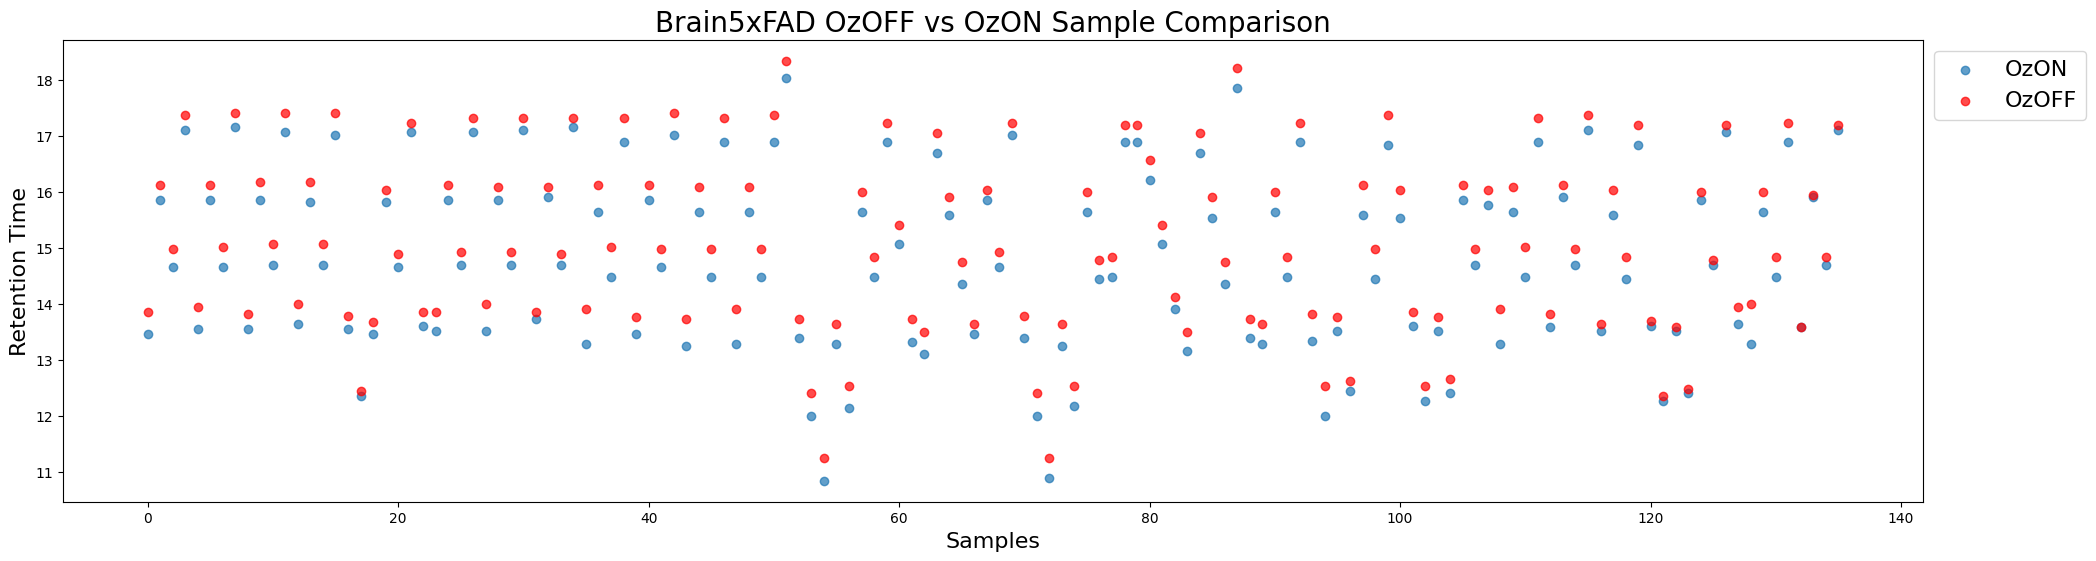

In [57]:


def plot_matched_scatter_and_create_df(df1, df2, match_columns, ozesi_intensity_threshold=50):
    """
    Plots a scatter plot for each match between two dataframes based on specified columns and creates a new DataFrame
    with one matching row from each DataFrame for each group. Removes matches where the difference in Correct_RT
    is greater than 3 and OzESI_Intensity is below 300.

    Args:
    df1 (pandas.DataFrame): The first DataFrame (OzON).
    df2 (pandas.DataFrame): The second DataFrame (OzOFF).
    match_columns (list): List of column names to match between df1 and df2.
    ozesi_intensity_threshold (float): The threshold for OzESI_Intensity. Default is 300.

    Returns:
    pandas.DataFrame: A DataFrame with one matching row from each DataFrame for each group.
    """
    # Apply OzESI_Intensity threshold
    df1 = df1[df1['OzESI_Intensity'] >= ozesi_intensity_threshold]
    df2 = df2[df2['OzESI_Intensity'] >= ozesi_intensity_threshold]

    # Select the first row for each group in both dataframes
    df1_grouped = df1.groupby(match_columns).first().reset_index()
    df2_grouped = df2.groupby(match_columns).first().reset_index()

    # Find common rows based on the match_columns
    common_rows = pd.merge(df1_grouped, df2_grouped, on=match_columns, suffixes=('_OzON', '_OzOFF'))

    # Calculate the difference in Correct_RT and filter out rows with difference > 0.5
    common_rows['RT_Diff'] = (common_rows['Correct_RT_OzON'] - common_rows['Correct_RT_OzOFF']).abs()
    common_rows = common_rows[common_rows['RT_Diff'] <= 0.8]

    # Assign a unique group number for each combination of match_columns
    common_rows['Group_Sample'] = common_rows.groupby(match_columns).ngroup()

    # Set the figure size
    plt.figure(figsize=(24, 6))

    # Plotting
    plt.scatter(common_rows['Group_Sample'], common_rows['Correct_RT_OzON'], label='OzON', alpha=0.7)
    plt.scatter(common_rows['Group_Sample'], common_rows['Correct_RT_OzOFF'], label='OzOFF', alpha=0.7, color='r')
    plt.xlabel('Samples', fontsize=16)
    plt.ylabel('Retention Time', fontsize=16)
    plt.title('Brain5xFAD OzOFF vs OzON Sample Comparison', fontsize=20)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
    #save directory
    # plt.savefig('Projects/FaceFats/plots/RT_shift/FF_Brain5xFAD_RTshift.png', bbox_inches='tight')
    plt.show()

    # Create a new DataFrame with Group_Sample and the match_columns
    df_OzOFFvsOzON_Matching = common_rows[['Group_Sample'] + match_columns + ['Correct_RT_OzON', 'Correct_RT_OzOFF']]

    return df_OzOFFvsOzON_Matching

# Usage Example
match_columns = ['Cage', 'Mouse', 'Genotype', 'Biology', 'Lipid']
df_OzOFFvsOzON_Matching = plot_matched_scatter_and_create_df(d_OzON, OzOFF_Correct_RT, match_columns)


std dev between ozoff and ozon

In [58]:
# Calculate the difference
df_OzOFFvsOzON_Matching['RT_Diff'] = df_OzOFFvsOzON_Matching['Correct_RT_OzON'] - df_OzOFFvsOzON_Matching['Correct_RT_OzOFF']

# Calculate mean and standard deviation of the difference
mean_diff = df_OzOFFvsOzON_Matching['RT_Diff'].mean()
std_dev_diff = df_OzOFFvsOzON_Matching['RT_Diff'].std()

print('mean dif =', abs(mean_diff).round(2),'std dev' ,std_dev_diff.round(2))
#rename Correct_RT_OzON to RT_OzON and Correct_RT_OzOFF to RT_OzOFF
# df_OzOFFvsOzON_Matching.rename(columns={'Correct_RT_OzON': 'RT_OzON', 'Correct_RT_OzOFF': 'RT_OzOFF'}, inplace=True)

df_OzOFFvsOzON_Matching


mean dif = 0.32 std dev 0.13


,Group_Sample,Cage,Mouse,Genotype,Biology,Lipid,Correct_RT_OzON,Correct_RT_OzOFF,RT_Diff
0,0,DOD93,F4,5xFAD,cereb,[TG(54:5)]_FA18:1,13.46,13.86,-0.40
1,1,DOD93,F4,5xFAD,cereb,"[TG(55:10),TG(54:3)]_FA18:1",15.86,16.12,-0.26
2,2,DOD93,F4,5xFAD,cereb,"[TG(55:11),TG(54:4)]_FA18:1",14.66,14.97,-0.31
3,3,DOD93,F4,5xFAD,cereb,"[TG(55:9),TG(54:2)]_FA18:1",17.10,17.37,-0.27
4,4,DOD93,F4,5xFAD,cortex,[TG(54:5)]_FA18:1,13.55,13.95,-0.40
...,...,...,...,...,...,...,...,...,...
133,131,FAD189,M2,5xFAD,dienc,"[TG(55:9),TG(54:2)]_FA18:1",16.88,17.23,-0.35
134,132,FAD189,M2,5xFAD,hippo,[TG(54:5)]_FA18:1,13.59,13.59,0.00
135,133,FAD189,M2,5xFAD,hippo,"[TG(55:10),TG(54:3)]_FA18:1",15.90,15.95,-0.05
136,134,FAD189,M2,5xFAD,hippo,"[TG(55:11),TG(54:4)]_FA18:1",14.70,14.84,-0.14


# Function to match OzON to OzOFF verify OzON Lipids are the correct lipids

In [59]:


## For loop version #1 very slow takes like 10 mins to run

def filter_df_based_on_rt_window(df1, df2, match_columns, rt_window=0.5):
    """
    Filters the first DataFrame based on matching 'Lipid' within each pairing of match_columns
    and a window for the Retention_Time based on the Correct_RT from the second DataFrame.

    Args:
    df1 (pandas.DataFrame): The first DataFrame to be filtered (d_OzON).
    df2 (pandas.DataFrame): The second DataFrame (OzOFF_Correct_RT).
    match_columns (list): List of column names for pairing ('Cage', 'Mouse', 'Genotype', 'Biology').
    rt_window (float): The window for the Retention_Time difference. Default is 0.5.

    Returns:
    pandas.DataFrame: A filtered version of df1 based on lipid matches within the RT window.
    """
    filtered_df = pd.DataFrame()

    # Iterate through each unique combination of match_columns with a progress bar
    for _, group in tqdm(df1.groupby(match_columns), desc="Processing Groups"):
        # Get the corresponding group in df2
        matching_group = df2[df2[match_columns].apply(tuple, axis=1).isin([tuple(group[match_columns].iloc[0])])]
        
        # Iterate through each row in the group from df1
        for _, row in group.iterrows():
            lipid = row['Lipid']
            rt = row['Retention_Time']
            
            # Check if there's a matching lipid within the RT window in df2
            matches = matching_group[(matching_group['Lipid'] == lipid) &
                                     (matching_group['Correct_RT'] >= rt - rt_window) &
                                     (matching_group['Correct_RT'] <= rt + rt_window)]
            
            # If matches are found, append to the filtered DataFrame
            if not matches.empty:
                filtered_df = filtered_df.append(row)

    return filtered_df

#Columns to match
match_columns = ['Cage', 'Mouse', 'Genotype', 'Biology']
#Retention time window
rt_window = 0.5  # User-specified retention time window
# Filter the DataFrame based off OzON RT window
d_OzON2 = filter_df_based_on_rt_window(d_OzON, OzOFF_Correct_RT, match_columns, rt_window)


Processing Groups: 100%|██████████| 24/24 [11:22<00:00, 28.45s/it]


Check to make sure for loops worked

In [60]:
d_OzON2

,Biology,Cage,Correct_RT,Genotype,Group_Sample,Lipid,Match_Group,Mouse,New_ID,OzESI_Intensity,Parent_Ion,Product_Ion,Retention_Time,Sample_ID,Transition
73490,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,362.100037,898.8,599.5,13.372283,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
73491,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,634.100037,898.8,599.5,13.416683,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
73492,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,2280.580078,898.8,599.5,13.461100,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
73493,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,944.100037,898.8,599.5,13.505500,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
73494,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,573.380066,898.8,599.5,13.549917,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355960,hippo,FAD189,17.10,5xFAD,706.0,"[TG(55:9),TG(54:2)]_FA18:1",3095.0,M2,"[TG(55:9),TG(54:2)]_FA18:1-FAD189-M2-5xFAD-hippo",174.480011,904.8,605.5,17.500900,11292023_FAD189_M2_5xFAD_hippo_O3on_01,904.8 -> 605.5
2355961,hippo,FAD189,17.10,5xFAD,706.0,"[TG(55:9),TG(54:2)]_FA18:1",3095.0,M2,"[TG(55:9),TG(54:2)]_FA18:1-FAD189-M2-5xFAD-hippo",249.940018,904.8,605.5,17.545317,11292023_FAD189_M2_5xFAD_hippo_O3on_01,904.8 -> 605.5
2355962,hippo,FAD189,17.10,5xFAD,706.0,"[TG(55:9),TG(54:2)]_FA18:1",3095.0,M2,"[TG(55:9),TG(54:2)]_FA18:1-FAD189-M2-5xFAD-hippo",378.500031,904.8,605.5,17.589717,11292023_FAD189_M2_5xFAD_hippo_O3on_01,904.8 -> 605.5
2355963,hippo,FAD189,17.10,5xFAD,706.0,"[TG(55:9),TG(54:2)]_FA18:1",3095.0,M2,"[TG(55:9),TG(54:2)]_FA18:1-FAD189-M2-5xFAD-hippo",443.540039,904.8,605.5,17.634133,11292023_FAD189_M2_5xFAD_hippo_O3on_01,904.8 -> 605.5


# plot all the groups for each lipid to make sure they all at the same RT

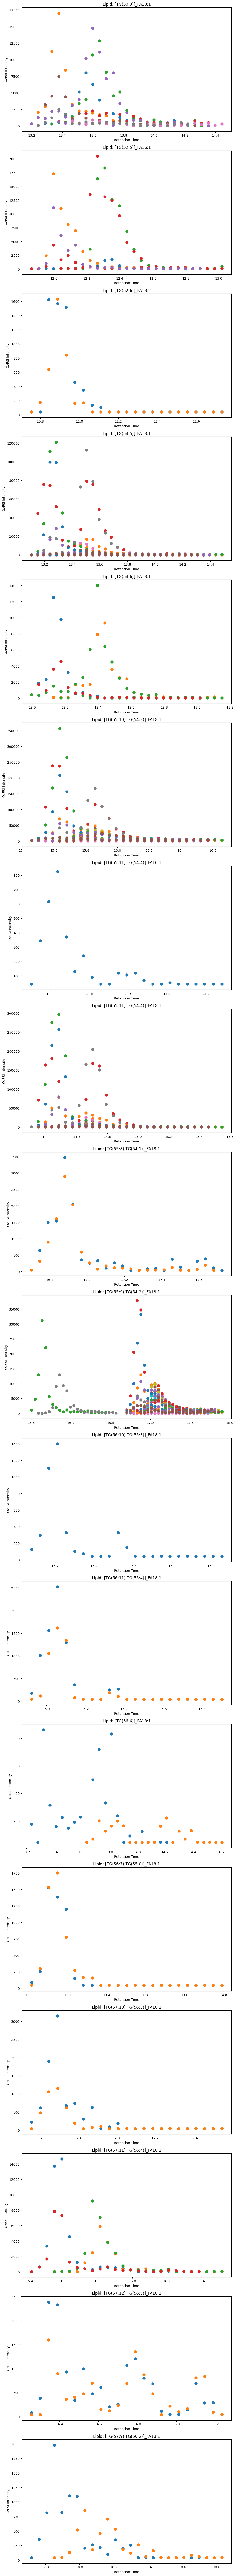

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame, replace with your actual DataFrame
# d_OzON2 = pd.DataFrame(...)

# Group by Lipid
lipid_groups = d_OzON2.groupby("Lipid")

# Determine the number of unique lipids to create subplots
num_lipids = len(lipid_groups)
fig, axes = plt.subplots(num_lipids, 1, figsize=(10, 6 * num_lipids))

# Check if axes is an array (when there are multiple lipids)
if not isinstance(axes, np.ndarray):
    axes = [axes]

# Plot each lipid group in a separate subplot
for (lipid, group), ax in zip(lipid_groups, axes):
    for _, sub_group in group.groupby(["Biology", "Cage", "Genotype"]):
        ax.plot(sub_group["Retention_Time"], sub_group["OzESI_Intensity"], marker='o', linestyle='', ms=8)
    ax.set_title(f"Lipid: {lipid}")
    ax.set_xlabel("Retention Time")
    ax.set_ylabel("OzESI Intensity")

plt.tight_layout()
plt.show()


# find max intensity of filtered_d_OzON 

In [62]:

def Correct_OzON_RT(df):
    """
    Assigns the Retention_Time of the row with the highest OzESI_Intensity
    for each group of Biology, Cage, Genotype, and Lipid as Correct_RT.

    Args:
        df (pandas.DataFrame): The DataFrame to process.

    Returns:
        pandas.DataFrame: The DataFrame with the new Correct_RT column.
    """
    # Group by the specified columns and find the max intensity for each group
    max_intensity_per_group = df.groupby(['Biology', 'Cage', 'Genotype', 'Lipid'])['OzESI_Intensity'].transform('max')

    # Mark the rows with the highest intensity in each group
    is_max_intensity = df['OzESI_Intensity'] == max_intensity_per_group

    # Copy the Retention_Time of the row with the max intensity to Correct_RT
    df['Correct_RT'] = df[is_max_intensity]['Retention_Time'].round(2)

    # Forward fill and backward fill Correct_RT within each group
    df['Correct_RT'] = df.groupby(['Biology', 'Cage', 'Genotype', 'Lipid'])['Correct_RT'].apply(lambda x: x.ffill().bfill())

    return df

# Usage example:
# Assuming your DataFrame is named 'filtered_d_OzON'
d_OzON3 = Correct_OzON_RT(d_OzON2)
d_OzON3

,Biology,Cage,Correct_RT,Genotype,Group_Sample,Lipid,Match_Group,Mouse,New_ID,OzESI_Intensity,Parent_Ion,Product_Ion,Retention_Time,Sample_ID,Transition
73490,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,362.100037,898.8,599.5,13.372283,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
73491,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,634.100037,898.8,599.5,13.416683,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
73492,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,2280.580078,898.8,599.5,13.461100,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
73493,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,944.100037,898.8,599.5,13.505500,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
73494,cereb,DOD93,13.46,5xFAD,9.0,[TG(54:5)]_FA18:1,2976.0,F4,[TG(54:5)]_FA18:1-DOD93-F4-5xFAD-cereb,573.380066,898.8,599.5,13.549917,11292023_DOD93_F4_5xFAD_cereb_O3on_01,898.8 -> 599.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355960,hippo,FAD189,17.10,5xFAD,706.0,"[TG(55:9),TG(54:2)]_FA18:1",3095.0,M2,"[TG(55:9),TG(54:2)]_FA18:1-FAD189-M2-5xFAD-hippo",174.480011,904.8,605.5,17.500900,11292023_FAD189_M2_5xFAD_hippo_O3on_01,904.8 -> 605.5
2355961,hippo,FAD189,17.10,5xFAD,706.0,"[TG(55:9),TG(54:2)]_FA18:1",3095.0,M2,"[TG(55:9),TG(54:2)]_FA18:1-FAD189-M2-5xFAD-hippo",249.940018,904.8,605.5,17.545317,11292023_FAD189_M2_5xFAD_hippo_O3on_01,904.8 -> 605.5
2355962,hippo,FAD189,17.10,5xFAD,706.0,"[TG(55:9),TG(54:2)]_FA18:1",3095.0,M2,"[TG(55:9),TG(54:2)]_FA18:1-FAD189-M2-5xFAD-hippo",378.500031,904.8,605.5,17.589717,11292023_FAD189_M2_5xFAD_hippo_O3on_01,904.8 -> 605.5
2355963,hippo,FAD189,17.10,5xFAD,706.0,"[TG(55:9),TG(54:2)]_FA18:1",3095.0,M2,"[TG(55:9),TG(54:2)]_FA18:1-FAD189-M2-5xFAD-hippo",443.540039,904.8,605.5,17.634133,11292023_FAD189_M2_5xFAD_hippo_O3on_01,904.8 -> 605.5


# Filter OzON2 dataframe down so that i only have 1 unqiue value for each New_ID

In [63]:
def filter_by_max_intensity_non_null_id(df, group_col, intensity_col):
    """
    Filters the DataFrame to keep only the row with the highest intensity for each non-null group.

    Args:
    df (pandas.DataFrame): The input DataFrame.
    group_col (str): The name of the column to group by.
    intensity_col (str): The name of the column with intensity values.

    Returns:
    pandas.DataFrame: A DataFrame with filtered values.
    """
    # Filter out rows where 'New_ID' is None
    filtered_df = df[df[group_col].notnull()]

    # Group by 'New_ID' and get the row with max 'OzESI_Intensity' in each group
    return filtered_df.loc[filtered_df.groupby(group_col)[intensity_col].idxmax()]

# Usage Example
OzON_Correct_RT = filter_by_max_intensity_non_null_id(d_OzON3, 'New_ID', 'OzESI_Intensity')
#reset index
OzON_Correct_RT.reset_index(drop=True, inplace=True)
# round Retention_Time to 2 decimal places
OzON_Correct_RT['Retention_Time'] = OzON_Correct_RT['Retention_Time'].round(2)
#drop Group_Sample column and Match_Group column and New_ID column
# OzON_Correct_RT.drop(columns=['Group_Sample', 'Match_Group', 'New_ID'], inplace=True)

#Save the file
OzON_Correct_RT.to_csv('Projects/FaceFats/data/OzON_CorrectRT/FF_Brain5xFAD_OzON_CorrectRT.csv')

OzON_Correct_RT


,Biology,Cage,Correct_RT,Genotype,Group_Sample,Lipid,Match_Group,Mouse,New_ID,OzESI_Intensity,Parent_Ion,Product_Ion,Retention_Time,Sample_ID,Transition
0,cereb,DOD94,13.55,5xFAD,123.0,[TG(50:3)]_FA18:1,2644.0,F4,[TG(50:3)]_FA18:1-DOD94-F4-5xFAD-cereb,8025.560547,846.8,547.5,13.55,11292023_DOD94_F4_5xFAD_cereb_O3on_01,846.8 -> 547.5
1,cortex,DOD94,13.60,5xFAD,153.0,[TG(50:3)]_FA18:1,2645.0,F4,[TG(50:3)]_FA18:1-DOD94-F4-5xFAD-cortex,2297.080078,846.8,547.5,13.60,11292023_DOD94_F4_5xFAD_cortex_O3on_01,846.8 -> 547.5
2,cereb,FAD185,13.38,5xFAD,363.0,[TG(50:3)]_FA18:1,2652.0,M3,[TG(50:3)]_FA18:1-FAD185-M3-5xFAD-cereb,17026.960938,846.8,547.5,13.38,11292023_FAD185_M3_5xFAD_cereb_O3on_01,846.8 -> 547.5
3,dienc,FAD185,13.38,5xFAD,423.0,[TG(50:3)]_FA18:1,2654.0,M3,[TG(50:3)]_FA18:1-FAD185-M3-5xFAD-dienc,7436.700684,846.8,547.5,13.38,11292023_FAD185_M3_5xFAD_dienc_O3on_01,846.8 -> 547.5
4,hippo,FAD185,13.38,5xFAD,453.0,[TG(50:3)]_FA18:1,2655.0,M3,[TG(50:3)]_FA18:1-FAD185-M3-5xFAD-hippo,2502.100098,846.8,547.5,13.38,11292023_FAD185_M3_5xFAD_hippo_O3on_01,846.8 -> 547.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,cortex,FAD189,15.77,5xFAD,533.0,"[TG(57:11),TG(56:4)]_FA18:1",3305.0,M1,"[TG(57:11),TG(56:4)]_FA18:1-FAD189-M1-5xFAD-co...",9192.380859,928.8,629.5,15.77,11292023_FAD189_M1_5xFAD_cortex_O3on_01,928.8 -> 629.5
134,cereb,FAD185,14.35,5xFAD,384.0,"[TG(57:12),TG(56:5)]_FA18:1",3276.0,M3,"[TG(57:12),TG(56:5)]_FA18:1-FAD185-M3-5xFAD-cereb",2385.320068,926.8,627.5,14.35,11292023_FAD185_M3_5xFAD_cereb_O3on_01,926.8 -> 627.5
135,dienc,FAD185,14.35,5xFAD,444.0,"[TG(57:12),TG(56:5)]_FA18:1",3278.0,M3,"[TG(57:12),TG(56:5)]_FA18:1-FAD185-M3-5xFAD-dienc",1596.720093,926.8,627.5,14.35,11292023_FAD185_M3_5xFAD_dienc_O3on_01,926.8 -> 627.5
136,hippo,FAD185,18.03,5xFAD,355.0,"[TG(57:9),TG(56:2)]_FA18:1",3347.0,M1,"[TG(57:9),TG(56:2)]_FA18:1-FAD185-M1-5xFAD-hippo",857.760071,932.9,633.6,18.03,11292023_FAD185_M1_5xFAD_hippo_O3on_01,932.9 -> 633.6
